# <a id='toc1_'></a>[Classification of SfM-derived point clouds using deep learning](#toc0_)

- 🥠 Deep Learning
- ☁️ SfM-derived Point Cloud
- 🛰️ Remote Sensing

<p align="center">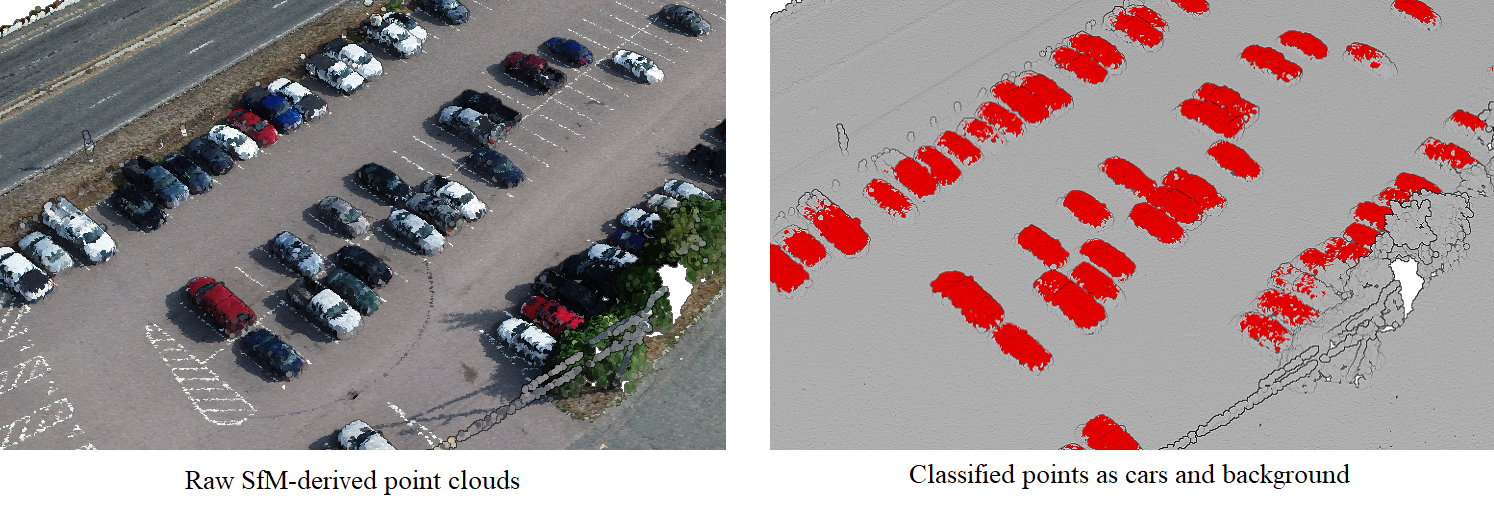</p>

**Table of contents**<a id='toc0_'></a>   
- [Introduction](#toc1_1_)    
- [Area of interest and pre-processing](#toc1_2_)    
- [Necessary Imports](#toc1_3_)    
- [Connect to your GIS portal](#toc1_4_)       
- [Data preparation](#toc1_5_)    
- [LAS Files to PCTD](#toc1_5_6_)    
- [Export the Point Cloud into Training Data Format](#toc1_5_7_)    
- [Understanding the Exported PCTD Data Structure](#toc1_5_8_)     
- [Preparing the data](#toc1_5_9_)     
- [Visualization of prepared data](#toc1_6_)    
- [Training the model](#toc1_7_)    
- [Visualization of results in notebook](#toc1_8_)    
- [Saving the trained model](#toc1_9_)    
- [Classification using the trained model (Inferencing)](#toc1_10_)    
- [Visualization of results in ArcGIS Pro](#toc1_11_)    
- [Visualization of Results in a Web Scene (ArcGIS Notebooks)](#toc1_12_)    
- [Conclusion](#toc1_13_)    
- [References](#toc1_14_)    

## <a id='toc1_1_'></a>[Introduction](#toc0_)

Historically, point clouds have been created by active remote sensing scanners, such as radar and laser scanners (LiDAR), that can be used on aerial, mobile, and terrestrial platforms. With the advancement in computer vision algorithms, point clouds can now also be created using Semi-Global Matching (SGM) and Structure from Motion (SfM) methods. These techniques are also based on overlapping imagery, just like 'manual stereo compilation', which is a photogrammetric method for creating point clouds. However, SfM and SGM methods both give far better and more detailed results and are less time consuming than the photogrammetric method <a href="#References">[1]</a>.

There are many technical terms that are loosely interchanged for such point clouds, such as SfM-derived point clouds, photogrammetric point clouds, synthetic point clouds, UAV point clouds, etc. In this sample notebook, we will be using the term: 'SfM-derived point clouds' with context to describe point clouds generated from ESRI's <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> and <a href="https://www.esri.com/en-us/arcgis/products/arcgis-drone2map/overview" target="_blank">ArcGIS Drone2Map</a>.  


SfM derived point clouds and LiDAR point clouds cannot be treated as the same. Some of the key differences between them are:

- Only the visible surface is modeled ('first returns') for SfM, SGM, or traditional photogrammetry methods <a href="#References">[1]</a>.


- Photo quality (exposure, shadows, etc.) and photo processing both have a significant impact on the quality of the generated point clouds in non-LiDAR approaches <a href="#References">[1]</a>.


- The SfM-derived point clouds can be enriched with the information for other imagery bands, like NIR. Even an NDVI band can be easily added as an additional attribute to the dataset <a href="#References">[1]</a>. 


- The geometry of the objects in SfM point clouds can have distorted/soft edges. This usually depends upon the quality of GCPs, variation in flying height of the drone, redundancies in overlapping imagery for a particular region, etc.


- In many cases, LiDAR-based data acquisition is costlier and requires more planning than drone imagery acquisition that generates point clouds using the SfM technique.



For these reasons, many of the traditional non-'deep learning' methods developed for LiDAR point clouds fall flat when it comes to SfM-derived point clouds. Fortunately, deep learning can fill this processing gap and help in the point cloud classification of these datasets.


Point clouds generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> are first labeled with the 'objects of interest' to create the training data. Next, deep learning capabilities in 'ArcGIS API for Python' are utilized for the classification of these SfM-derived point clouds.

Further details on the RandLANet implementation in the API <i>(working principle, architecture, best practices, etc.)</i>, can be found in the <a href="https://developers.arcgis.com/python/guide/point-cloud-segmentation-using-randlanet" target="_blank">RandLANet guide</a>, along with instructions on how to set up the Python environment. Additional sample notebooks related to RandLANet can be found in the <a href="https://developers.arcgis.com/python/sample-notebooks/" target="_blank">sample notebook section</a> on the website.

Before proceeding through this notebook, it is advised that you go through the <a href="https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#randlanet" target="_blank">API reference</a> for RandLANet (`prepare_data()`, `Transform3d()`, and `RandLANet()`), along with the resources and tool references for point cloud classification using deep learning in ArcGIS Pro, found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

### 🎯 Objective

The objective of this notebook is to **classify points representing cars** in SfM-derived point clouds using ArcGIS API's **RandLANet model**. A model will be trained for two classes:

- `cars`  
- `background`

Additional attributes (Red, Green, Blue) are also used for model training alongside the geometric information.

### 📚 What You'll Learn

By the end of this notebook, you will learn how to:

- Prepare SfM-derived point cloud data for deep learning.
- Convert LAS files into a deep learning-compatible format (PCTD).
- Load and apply pretrained or custom models for point cloud classification.
- Train a RandLANet model on labeled SfM-derived point clouds.
- Visualize point cloud data and classification results.
- Classify new point cloud datasets using the trained model.
- Visualize results in ArcGIS Pro or within Jupyter Notebook.

### 🧰 Tools & Technologies

- **LAS datasets from SfM-derived point clouds**  
- **ArcGIS API for Python**
- **ArcGIS Pro 3D Analyst / Point Cloud tools**
- **RandLANet deep learning model**  
- **Jupyter Notebook** for workflow management  
- **ArcGIS Pro for inferencing and visualization**

### 📂 Dataset Description

- **Source:** SfM-derived point clouds generated from drone imagery using ESRI's **Site Scan for ArcGIS** and **ArcGIS Drone2Map**.  
- **Classes:**  
  - `cars` → class code 18  
  - `background` → class code 0  
- **Pre-processing:** LAS files are split into **training**, **validation**, and **test** sets. LAS datasets are created using **ArcGIS Pro** tools. Polygons may be used to define regions of interest.  

### 🗺️ Workflow Overview

The notebook follows a structured pipeline:

1. **Data Extraction/Collection**  
   - Download and extract point cloud datasets.  

2. **Training Data Export**  
   - Export LAS files to **PCTD format**.  

3. **Data Preparation/Preprocessing**  
   - Prepare PCTD training and validation blocks into a model-ready format.
   - Output: A **DataBunch object** ready for RandLANet.

4. **Visualization of Prepared Data**  
   - Explore the training and validation blocks visually.

5. **Model Preparation**  
   - Initialize the RandLANet model (efficient semantic segmentation model for large point clouds) and configure parameters.  

6. **Training the Model**  
   - Train the model with training blocks.  
   - Monitor learning rate, early stopping, and metrics.  

7. **Inference / Classification**  
   - Apply the trained model to test data.  

8. **Results Visualization**  
   - Visualize classification results in Jupyter Notebook or ArcGIS Pro 3D web scene.  

9. **Model Saving**  
   - Save the trained model and its folder structure for future use.  

10. **Analysis & Insights**  
    - Review classification results, verify accuracy, and analyze patterns.

## <a id='toc1_2_'></a>[Area of interest and pre-processing](#toc0_)

Any SfM-derived point clouds and areas of interest can be used, but for this sample, we are using point clouds generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a>, using drone imagery of some parking lots in the United States. The dataset already has points labeled for `cars`, represented by classcode `18`, and `background`, represented by classcode `0`.

_**Pre-processing steps:**_

- Split the `.las` files into three unique sets, one for training, one for validation, and one for testing. Create LAS datasets for all three sets using the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-las-dataset.htm" target="_blank">Create LAS Dataset</a>  tool. There is no fixed rule, but generally, the validation data for point clouds in `.las` format should be at least 5-10 % <i>(by size)</i> of the total data available, with appropriate diversity within the validation dataset. <i>(For ease in splitting the big `.las` files into the appropriate ratios, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/tile-las.htm" target="_blank">Tile LAS</a> tool can be used.)</i>


- Alternatively, polygons can also be used to define regions of interest that should be considered as training or validation datasets. These polygons can be used later in the export tool. If the dataset is very large, then the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/build-las-dataset-pyramid.htm" target="_blank">Build LAS Dataset Pyramid</a> tool can be leveraged for faster rendering/visualization of the data, which will also help in exploring and splitting the dataset.


- If there is a pre-trained imagery model for the object of interest, then that model can help in creating the training dataset. The pre-trained imagery model can be used on the data from which the SfM-derived point cloud was created. Later, the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/set-las-class-codes-using-raster.htm" target="_blank">Set LAS Class Codes Using Raster</a> tool or the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/set-las-class-codes-using-features.htm" target="_blank">Set LAS Class Codes Using Features</a>  tool can be used to classify point cloud datasets using vector or raster labels obtained from the imagery pre-trained model. For example, in this sample notebook, the objects of interest are car(s), and overlapping drone imagery is used to generate the point clouds. As such, ESRI's <a href="https://arcg.is/1OabnW" target="_blank">Car Detection - USA model</a> can be used on the orthophoto to generate car footprint polygons that can later be used to classify cars in the point cloud. Also, as the point cloud is derived from the imagery, moving objects, like a `car`, will not change positions, which can happen when using LiDAR data.

## <a id='toc1_3_'></a>[Necessary Imports](#toc0_)

In this section, we load the Python and ArcGIS modules needed for point-cloud classification. These imports handle data preparation, model training, 3D transformations, and communication with your ArcGIS portal.

In [1]:
# 📁 Standard Python Libraries
# General-purpose modules used throughout the notebook
# =================================================================================================

import os                                            # Enables interaction with the operating system (paths, files, directories)
import zipfile                                       # Supports creation/extraction of .zip archives (useful for packaging outputs)
from pathlib import Path                             # Object-oriented and cross-platform path handling
from datetime import datetime                        # Allows creation of timestamped folder and file names
import tempfile                                      # Provides temporary directories for safe, isolated processing


# 🛰️ ArcGIS API for Python Imports
# Modules used for authentication, point-cloud preparation, and training RandLANet
# =================================================================================================

import arcpy                                         # ArcGIS geoprocessing library (used for LAS/point cloud tools, spatial operations)
from arcgis.gis import GIS                           # Connects to ArcGIS Online or ArcGIS Enterprise portals
from arcgis.learn import (                           # ArcGIS deep learning components for 3D workflows
    prepare_data,                                    # Creates training datasets for point-cloud models
    Transform3d,                                     # Performs 3D data augmentations for point-cloud training
    RandLANet                                        # Neural network model tailored for efficient 3D point-cloud classification
)

from arcgis.map import Scene                         # Scene object for working with 3D visualization in ArcGIS

# Confirm that everything imported correctly
print("✅ Package imports completed successfully.")

✅ Package imports completed successfully.


## <a id='toc1_4_'></a>[Connect to your GIS portal](#toc0_)

Before you can access maps, layers, or run deep learning models, you need to connect to an **ArcGIS Online** or **ArcGIS Enterprise** portal using the `GIS` class from the ArcGIS API for Python.

Connection options:

#### <a id='toc1_4_1_1_'></a>[Automatic Connection (Recommended for ArcGIS Pro / Online / Enterprise Notebooks)](#toc0_)
This method is ideal when you are:

- Using **ArcGIS Pro Notebook**
- Using **ArcGIS Enterprise/Online (Notebook Server)**
- Already signed in to ArcGIS

In these environments, your credentials are inherited automatically; simply use -

```python
gis = GIS("home")
```

#### <a id='toc1_4_1_2_'></a>[Manual Connection (For Standalone Scripts)](#toc0_)

If you’re using a standalone Jupyter Notebook, connect manually:
```python
gis = GIS("https://www.arcgis.com", "your_username", "your_password")
```

Replace:

- https://www.arcgis.com → your portal URL (for Enterprise users, this might differ).
- "your_username" and "your_password" → valid credentials.

📘 Reference:

See the [ArcGIS API for Python – GIS](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis) class documentation for full details

In [2]:
# Connect to your active ArcGIS session
# -----------------------------
gis = GIS('home')

# Verify connection by printing your username
# -----------------------------
print(f"Connected to ArcGIS as: {gis.users.me.username}")

Connected to ArcGIS as: gis_python


## <a id='toc1_5_'></a>[Data preparation](#toc0_)

### <a id='toc1_5_1_'></a>[Fetch Raw SfM Point-Cloud Dataset from ArcGIS Online](#toc0_)

In this step, we retrieve the raw LAS dataset containing the SfM-derived point cloud. This is the source data that will later be exported into deep learning training samples using geoprocessing tools. It contains both `training data` and `test data`, where the `test data` is used for inferencing.

You can retrieve any **ArcGIS Online** or **Enterprise** item using:

```Python
gis.content.get(<item_id>)
```

Where:

- `gis` → your active **ArcGIS portal connection**
- `.content` → manager for items stored in your portal
- `.get(item_id)` → loads the item using its unique identifier string

Once retrieved, the dataset can be downloaded, inspected, or processed further in later steps.

<Item title:"Raw_Dataset_Classification_of_sfm_derived_point_clouds_using_deep_learning" type:Image Collection owner:api_data_owner>
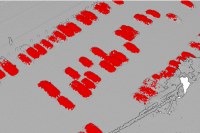

✅ Raw point-cloud dataset successfully loaded from ArcGIS Online.


In [3]:
# 🧭 Fetch the Raw SfM-Derived Point Cloud Dataset
# -------------------------------------------------------------------
# This item contains the original LAS files (raw data). These files will be exported into deep learning training samples later in the workflow.

raw_dataset = gis.content.get('cae020a8e7f24fedb1359d114ca3abf1')


# Verify that the raw dataset item exists
# -------------------------------------------------------------------
# If successfully retrieved, 'raw_dataset' will not be None.
# display() shows the item details in the notebook (title, thumbnail, metadata).
# If retrieval fails, the user is alerted to check the Item ID or permissions.

if raw_dataset is not None:
    display(raw_dataset)
    print("✅ Raw point-cloud dataset successfully loaded from ArcGIS Online.")
else:
    print("⚠️ Raw dataset not found. Please verify the Item ID or your ArcGIS connection.")

### <a id='toc1_5_2_'></a>[📌 Download the Training Dataset](#toc0_)

After fetching the raw SfM-derived point-cloud item from ArcGIS Online, the next step is to download the dataset locally.
This dataset is downloaded as a `.zip` file, which will later be extracted and used for exporting point-cloud training blocks.

Syntax:
  `raw_dataset.download(file_name=<desired_name>)`
Where:
  - `raw_dataset`                 → the item object retrieved from `ArcGIS Online`
  - `.download()`                 → method to download the item’s data
  - `raw_dataset.download()`      → Downloads the data item from `ArcGIS Online` or `Enterprise`. The method returns the full path (as a string) to the downloaded file.
  - `file_name`                   → optional argument to specify the downloaded file’s name

In [4]:
# 🧩 Download the training data ZIP file
# ------------------------------------------------------------
# This downloads the original LAS files to a local temporary directory.
# The returned 'filepath' is the full path to the downloaded ZIP file.

filepath = raw_dataset.download(file_name=raw_dataset.name)

# 🔍 Verify if the file was successfully downloaded
# ------------------------------------------------------------
# `Path` is used for filesystem path handling (from pathlib)
# `Path(filepath).exists()`: Checks whether the file physically exists on disk. If it does, we confirm success and display the location.
# `Path.home()`: Gets the current user's home directory (e.g., C:\Users\JohnDoe).

if Path(filepath).exists():
    print("✅ Dataset downloaded successfully: ", str(filepath).replace(str(Path.home()), "<USER_HOME>"))
else:
    print("⚠️ Dataset download failed: File not found at ", str(filepath).replace(str(Path.home()), "<USER_HOME>"))

✅ Dataset downloaded successfully:  <USER_HOME>\AppData\Local\Temp\Classification_of_sfm_derived_point_clouds_using_deep_learning.zip


### <a id='toc1_5_3_'></a>[📦 Extract the Training Dataset](#toc0_)

In [5]:
# 📦 Extract the Downloaded ZIP File
# ------------------------------------------------------------

# This cell extracts the downloaded training dataset into the same directory as the ZIP file. It uses Python’s built-in 'zipfile' module.
# Open the downloaded ZIP file using a context manager ('with' ensures proper closing)
# 'filepath' is the full path to the ZIP file downloaded earlier
# The mode 'r' means we're opening the ZIP file in read-only mode

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    
    # Extract all the contents of the ZIP file into the same folder
    # 'Path(filepath).parent' returns the directory containing the ZIP file. Example: if the ZIP file is in 'C:\Temp\data.zip', extraction goes to 'C:\Temp\' inside a folder named `data`.
    zip_ref.extractall(Path(filepath).parent)

# Print a success message once extraction completes without error
print("✅ Dataset extracted successfully.")

✅ Dataset extracted successfully.


This below cell defines the location where the training data was extracted. The dataset ZIP file, when extracted, usually creates a folder with the same base name as the ZIP (e.g., removing the ".zip" extension).

`os.path.splitext(filepath)`: Splits the file path into two parts: the base name and the extension. Here it removes the `.zip` extension from the ZIP filename.

For example:

    If `filepath` = "C:/Temp/Classification_of_sfm_derived_point_clouds_using_deep_learning.zip"
    
    Then `os.path.splitext(filepath)[0]` = "C:/Temp/Classification_of_sfm_derived_point_clouds_using_deep_learning"

Wrapping it in `Path()` converts it into a `Path` object (preferred for modern path operations).

In [6]:
# 📁 Get the Path of the Extracted Folder
# ------------------------------------------------------------
# filepath → path to the downloaded ZIP
# os.path.splitext removes ".zip" and returns the base folder name.

output_path = Path(os.path.splitext(filepath)[0])

# Print the final path.
print("📁 Data folder ready at: ", str(output_path).replace(str(Path.home()), "<USER_HOME>"))

📁 Data folder ready at:  <USER_HOME>\AppData\Local\Temp\Classification_of_sfm_derived_point_clouds_using_deep_learning


### <a id='toc1_5_4_'></a>[📂 Understanding the Downloaded Dataset Structure](#toc0_)

**Dataset Folder Tree**
```
Classification_of_sfm_derived_point_clouds_using_deep_learning
            ├───test data
            │       west bridgewater.las
            │       west bridgewater.lasx
            │
            └───training data
                │   train.lasd
                │   val.lasd
                │
                ├───train
                │       berlin.las
                │       berlin.lasx
                │       millbury.las
                │       millbury.lasx
                │       milton.las
                │       milton.lasx
                │       rockland.las
                │       rockland.lasx
                │
                └───val
                        auburn.las
                        auburn.lasx
```

#### <a id='toc1_5_4_1_'></a>[📂 Root Folder - **`Classification_of_sfm_derived_point_clouds_using_deep_learning/`**](#toc0_)

This is the main dataset folder, downloaded from **ArcGIS Online**. It contains both the **testing** (`test data/`) and **training** (`training data/`) point-cloud data that will be used throughout the workflow.

#### <a id='toc1_5_4_2_'></a>[📂 `test data/`](#toc0_)
This folder contains the **test dataset**, which is used **only during inference**, not during training. Used after training to check real-world performance. It contains -
- **`west bridgewater.las`** - A `LAS` file containing raw point-cloud points. Used as unseen data to evaluate the trained model.
- **`west bridgewater.lasx`** - A `LAS index` file is automatically created by **ArcGIS**. Stores spatial indexing to speed up display, filtering, analysis. Required by ArcGIS Pro but **does not contain point-cloud data itself**.

#### <a id='toc1_5_4_3_'></a>[📂 `training data/`](#toc0_)
This folder contains all datasets required for **training and validating** the deep learning model. It includes:
- LAS dataset files (`.lasd`)
- A folder of training tiles (`train/`)
- A folder of validation tiles (`val/`)

##### <a id='toc1_5_4_3_1_'></a>[📘 LAS Dataset (`.lasd`) Files - **References**](#toc0_)
- **`train.lasd`**   → references the LAS files under `training data/train/` 
- **`val.lasd`**     → references the LAS files under `training data/val/`

A **LASD** file acts as a *container* or *catalog* for multiple `.las` files.  ArcGIS uses `.lasd` to manage multiple LAS tiles, metadata, coordinate systems, and visualization settings. These LASD datasets are used when exporting **PCTD training blocks**:
```Python
in_point_cloud = train.lasd
validation_point_cloud = val.lasd
```

##### <a id='toc1_5_4_3_2_'></a>[📂 `train/` - Contains multiple training LAS tiles, each representing a section of the training area. Each pair of files contains:](#toc0_)
- `xy.las` → the actual LiDAR/SfM point-cloud data. Example: `berlin.las`
- `xy.lasx` → the spatial index for fast processing. Example: `berlin.lasx`

These files are combined through the `train.lasd` dataset.

##### <a id='toc1_5_4_3_3_'></a>[📂 `val/` - Contains LAS tiles used for validation, ensuring the model is evaluated on different areas than the training dataset. Each tile contains:](#toc0_)
- `.las` — LiDAR/SfM point cloud
- `.lasx`—Spatial index
Using separate validation areas prevents overfitting and enables reliable accuracy estimation.

#### <a id='toc1_5_4_4_'></a>[📘 What Each File Type Means](#toc0_)

| File Type | Meaning | Purpose |
|----------|---------|---------|
| **`.las`** | Raw point-cloud file containing XYZ, RGB, intensity, return info, and classification codes | Core data used for training, validation, and testing |
| **`.lasx`** | Spatial index file automatically created by ArcGIS | Speeds up display, filtering, and spatial queries |
| **`.lasd`** | LAS Dataset file — a container referencing multiple `.las` files | Used as input to geoprocessing tools (training/validation datasets) |

### <a id='toc1_5_5_'></a>[Define Training, Validation, and Export Paths](#toc0_)

Before exporting point clouds for deep learning, we first define the **paths** to the required input files. This step is essential because:
- The **training** and **validation** datasets live in separate files/folders (`train.lasd`, `val.lasd`)
- The export tool needs **absolute local paths** to these LASD files
- The output `.pctd` file must be written to a **clean, well-structured folder**

This preparation step avoids errors and automates the workflow.

In [7]:
# 🗂️ Define Paths for Training, Validation, and Exported Output
# ---------------------------------------------------------------------

# Construct the full path to the *training* LAS dataset (.lasd file). `os.path.join()` safely concatenates folder paths across all OS types.
train_point_cloud_path = os.path.join(output_path, "training data", "train.lasd")

# Construct the full path to the *validation* LAS dataset. This will be used by the `PreparePointCloudTrainingData` tool to evaluate the model during training.
validation_point_cloud_path = os.path.join(output_path, "training data", "val.lasd")

# Define the full output path where the exported Point Cloud Training Data (.pctd) folder will be created. This folder will contain the pre-processed blocks for deep learning.
exported_data_path = os.path.join(output_path, "project", "exported_data.pctd")

# Extract only the folder portion of 'exported_data_path'. `os.path.dirname()` returns the parent directory of a file path. Example: "C:/data/project/exported_data.pctd" → "C:/data/project"
exported_folder = os.path.dirname(exported_data_path)

# Check if the output folder already exists. If not → create it using `os.makedirs()`.
if not os.path.exists(exported_folder):
    os.makedirs(exported_folder)  # Creates all intermediate directories if they do not exist.
    print(f"📂 Created folder: {exported_folder.replace(str(Path.home()), '<USER_HOME>')}")
else:
    print(f"📂 Folder already exists: {exported_folder.replace(str(Path.home()), '<USER_HOME>')}")

📂 Created folder: <USER_HOME>\AppData\Local\Temp\Classification_of_sfm_derived_point_clouds_using_deep_learning\project


### <a id='toc1_5_6_'></a>[📦 LAS Files to PCTD](#toc0_)

LAS files are excellent for storing LiDAR/SfM point clouds but **not ideal for deep learning workflows**. Deep learning models (**RandLANet**, **KPConv**, **PointCNN**, etc.) require **structured, uniform, GPU-efficient data**, whereas LAS files are:
- Large and variable in point density  
- Unordered (not arranged in fixed-size structures)  
- Slow to load repeatedly during training  
- Designed for GIS workflows, not batch-based ML  

These limitations make it difficult to feed LAS files directly into neural networks. Deep learning frameworks such as PyTorch and TensorFlow expect:
- **fixed-size batches**  
- **dense numeric tensors**  
- **consistent number of points per sample**  
- **fast random-access I/O** for training loops  

LAS files do *not* meet these requirements.

#### <a id='toc1_5_6_1_'></a>[🔍 LAS vs. Deep Learning Needs](#toc0_)

| LAS Property | Deep Learning Requirement |
|--------------|---------------------------|
| Irregular, unstructured points | Structured blocks/tensors |
| Large, tile-based storage | Small, uniform samples |
| Slow disk access | High-throughput data streaming |
| Variable point density | Consistent point count per batch |

Thus, LAS → PCTD conversion is necessary to make point-cloud data **deep-learning compatible**.

#### <a id='toc1_5_6_2_'></a>[🧠 What Is PCTD?](#toc0_)

**PCTD (Point Cloud Training Data)** is a deep-learning–ready data format used in ArcGIS. It is built on the **HDF5** (Hierarchical Data Format v5) standard, widely used in scientific computing because it is:
- fast  
- compressed  
- hierarchical  
- optimized for large numeric datasets  

PCTD stores everything needed for training 3D point-cloud models in one file. It contains:

| Content | Description |
|--------|-------------|
| **Training blocks** | Point-cloud splits based on block size (e.g., 50 m) |
| **Validation blocks** | Separate data used during training evaluation |
| **XYZ coordinates** | Raw/normalized points |
| **Features** | RGB, intensity, return numbers, class codes |
| **Labels** | Ground-truth classes |
| **Statistics** | Point density, class histograms |
| **Metadata** | CRS, block size, attributes, limits |

Everything is pre-organized in a format that deep-learning frameworks can read efficiently. Exporting LAS → PCTD enables:

- ✔ **Uniform spatial blocks**  
- ✔ **Fixed number of points per sample** (`block_point_limit`)  
- ✔ **Fast I/O for GPUs** (HDF5 optimized)  
- ✔ **Compact and portable datasets**  
- ✔ **Full compatibility with ArcGIS deep-learning models**  
- ✔ **Preprocessing (indexing, normalization) handled automatically**  

This dramatically improves training speed, consistency, and model performance.

#### <a id='toc1_5_6_3_'></a>[🏗 How PCTD Is Generated](#toc0_)

Using the **Prepare Point Cloud Training Data** tool (3D Analyst extension), available in two ways:

##### <a id='toc1_5_6_4_'></a>[Using the **ArcGIS Pro Tool UI**](#toc0_)
  - <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool from the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a> available from **ArcGIS Pro 2.8** onwards (as shown in figure 1)</i>
  - Suitable for users who prefer graphical workflows

##### <a id='toc1_5_6_5_'></a>[Programmatically using **`arcpy`**](#toc0_)
  - Enables automation and integration into custom  end-to-end pipelines
  - The notebook uses this method for fully automated data preparation

The tool requires:

| Parameter                        | Explanation                                                 | Notes                                                         | Value Used in This Notebook   |
| -------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------------- | ----------------------------- |
| **Input Point Cloud**            | LAS or LASD dataset used for training blocks                | Required                                                      | `train_point_cloud_path`      |
| **Training Boundary Features**   | Optional polygons that restrict the training extent         | Needed if no validation dataset is provided                   | `None`                        |
| **Validation Point Cloud**       | LAS or LASD dataset used for validation during training     | Recommended to avoid overfitting                              | `validation_point_cloud_path` |
| **Validation Boundary Features** | Optional polygons defining validation regions               | Needed if training and validation come from the same LAS file | `None`                        |
| **Output Training Data**         | Path where the `.pctd` file will be stored                  | Required                                                      | `exported_data_path`          |
| **Block Size**                   | Size of training blocks (50 m recommended for most objects) | Linear unit                                                   | `"50 Meters"`                 |
| **Block Point Limit**            | Max points per block (default: 8192)                        | Prevents memory overflow                                      | `8192`                        |
| **Class Codes of Interest**      | LAS class codes to include                                  | Optional                                                      | `None`                        |
| **Excluded Class Codes**         | LAS class codes to exclude from training                    | Optional                                                      | `[]`                          |
| **Reference Surface**            | Raster used to compute relative height                      | Optional                                                      | `None`                        |

### <a id='toc1_5_7_'></a>[🛠️ Export the Point Cloud into Training Data Format](#toc0_)

In this step, raw `.las` point-cloud files are converted into the binary **Point Cloud Training Data (PCTD)** format.

The screenshot below shows the **Prepare Point Cloud Training Data** tool in ArcGIS Pro with all parameters filled in to export the training dataset.

<center>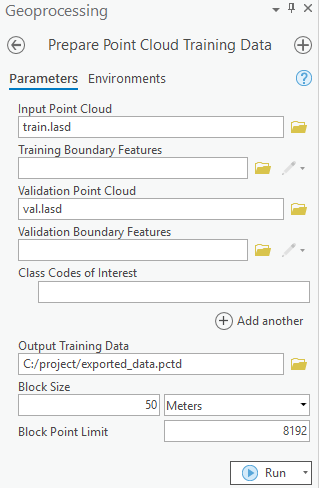</center>

<center>Figure 1. Exporting point-cloud training data using the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> geoprocessing tool in ArcGIS Pro.</center>




The code snippet below is the **ArcPy version generated automatically** from the tool UI and is used in this notebook to automate the workflow for exporting to PCTD format:

In [8]:
# 🛠️ Export Raw Point Cloud to HDF5 Training Blocks using arcpy
# -------------------------------------------------------------------
# This step converts the input LAS datasets (training + validation) into the HDF5-based Point Cloud Training Data (.pctd) format.
# The exported dataset will be used for deep learning workflows such as RandLANet, PointCNN, or KPConv.

arcpy.ddd.PreparePointCloudTrainingData(
    in_point_cloud = train_point_cloud_path,            # Path to the LASD containing training point clouds
    block_size = "50 Meters",                           # Block size for dividing the point cloud into training chunks
    out_training_data = exported_data_path,             # Output location for the generated .pctd file
    training_boundary = None,                           # No polygon boundary → use the full extent for training
    validation_point_cloud = validation_point_cloud_path,  # LASD containing validation point clouds
    validation_boundary = None,                         # No polygon boundary → use the full extent for validation
    class_codes_of_interest = None,                     # None → include all LAS class codes in the export
    block_point_limit = 8192,                           # Maximum number of points allowed per block
    reference_height = None,                            # No height normalization raster provided
    excluded_class_codes = []                           # No classes are excluded from export
)

print("✅ Point cloud successfully exported to PCTD format.")

✅ Point cloud successfully exported to PCTD format.


Now, you can check the exported data at `<USER_HOME>\AppData\Local\Temp\Classification_of_sfm_derived_point_clouds_using_deep_learning\project`

### <a id='toc1_5_8_'></a>[Understanding the Exported PCTD Data Structure](#toc0_)
When the tool processes LAS/LASD point-cloud data, it breaks the input into smaller, fixed-size pieces that can be used directly for deep-learning workflows. The exported folder contains everything needed to train and validate a model.

```
            ├───project
                   └───exported_data.pctd
                       ├───train
                       │   │   BlockPointCountHistogram.png
                       │   │   ListTable.h5
                       │   │   Statistics.json
                       │   │
                       │   └───0
                       │       ├───0
                       │       │   └───0
                       │       │           Data_0.h5, Data_1.h5, Data_2.h5, Data_3.h5, Data_4.h5
                       │       │
                       │       ├───1
                       │       │   └───0
                       │       │           Data_0.h5, Data_1.h5, Data_2.h5, Data_3.h5, Data_4.h5
                       │       │
                       │       ├───2
                       │       │   └───0
                       │       │           Data_0.h5, Data_1.h5, Data_2.h5, Data_3.h5, Data_4.h5
                       │       │
                       │       └───3
                       │           └───0
                       │                   Data_0.h5, Data_1.h5, Data_2.h5, Data_3.h5, Data_4.h5
                       │
                       └───val
                           │   BlockPointCountHistogram.png
                           │   ListTable.h5
                           │   Statistics.json
                           │
                           └───0
                               ├───0
                               │   └───0
                               │           Data_0.h5
                               │
                               ├───1
                               │   └───0
                               │           Data_0.h5
                               │
                               ├───2
                               │   └───0
                               │           Data_0.h5
                               │
                               └───3
                                   └───0
                                           Data_0.h5
```

Below is a breakdown of what each part of the output represents and why it is organized the way it is.

#### <a id='toc1_5_8_1_'></a>[📂 `train/` — Training Blocks](#toc0_)
The **train** folder contains all the blocks to be used during the actual learning phase. These blocks are produced by dividing the original point-cloud data into **uniform spatial tiles**—commonly something like 50-meter squares—and then limiting each tile to a maximum number of points so they can be processed efficiently by the neural network. Each `.h5` tile stores the full set of data that the model will learn from, including **coordinates, intensity or RGB values, LAS attributes, class labels, and any indices or masks** required by the training framework. These HDF5 files are the core of the dataset; everything else in the folder structure exists to help the training script load and interpret them correctly. Alongside the data tiles themselves, the folder includes several supporting files. **Statistics.json** summarizes attribute ranges, class distributions, and export settings, providing an easy way to assess the health and composition of the dataset. **ListTable.h5** serves as the dataset’s index that the training code uses to locate each block and how the nested directories relate to one another. During training, the loader reads this table to navigate through the dataset consistently and efficiently, ensuring every tile is discovered and accessed in the correct order. A **BlockPointCountHistogram.png** is also included to visualize how many points ended up in each tile, making it simple to spot cases where blocks are unusually sparse or overly dense.

Beneath these files is a **nested folder structure** (`0/0/0/...`). This layout is **intentional**. The **PCTD format** divides data into multiple **hierarchical layers** to keep huge collections of tiles organized. When working with point-cloud datasets, it’s common for the export process to generate hundreds or even thousands of individual training tiles. Instead of placing all these files into a single directory—which would slow down indexing, file discovery, and data loading—the PCTD format organizes them into a deeper folder hierarchy. The nested arrangement groups blocks into according to **internal split indices, block groups, and sub-blocks** defined during the export process, which helps the training system load them in **parallel and distribute** them efficiently across multiple workers or GPUs. This layered approach keeps the dataset scalable and well-structured, especially when dealing with very large point-cloud collections. At the lowest level of this structure are the `Data_N.h5` files, each one representing a single, ready-to-use point-cloud tile containing coordinates, intensity or RGB, classification labels, and all associated LAS attributes. Because the tiles are **normalized and uniformly sized**, they are ready to be streamed efficiently onto the GPU during training.

#### <a id='toc1_5_8_2_'></a>[📂 `val/`—Validation Blocks](#toc0_)
The **val** folder mirrors the structure of the training folder but contains only the blocks reserved for validation. These tiles are taken from **different spatial areas than the training tiles** so the model can be evaluated fairly. During training, these validation tiles are used to **measure loss, accuracy, and overall performance** without influencing the model’s weights. As a result, the validation folder usually contains fewer `.h5`files—validation aims for stable, representative samples, not large quantities of data. For this reason, each validation block typically appears as a single **Data_0.h5**, while training blocks may be split into multiple files, such as Data_0.h5 through Data_4.h5 if they contain more points than the allowed maximum.

Together, these folders and metadata files form a complete, deep-learning-ready dataset. The PCTD structure ensures that point-cloud tiles are stored efficiently, indexed cleanly, and ready for high-performance loading during training. It provides everything a model needs: organized **training data, separate validation data, block statistics, a lookup table** for fast access, and simple visual checks for dataset balance and quality.

| Component | Purpose |
|----------|---------|
| `train/` | Training blocks for the model |
| `val/` | Validation blocks for accuracy monitoring |
| `Data_*.h5` | Actual point-cloud blocks ready for GPU training |
| `Statistics.json` | Metadata & attribute statistics |
| `ListTable.h5` | Index file mapping blocks |
| `BlockPointCountHistogram.png` | Visual quality check |

Together, these form a **self-contained, efficiently organized, deep-learning-ready dataset**. Here, all the additional attributes are included in the exported data. Later, a subset of additional attributes, like intensity, number of returns, etc., can be selected that will be considered for training.

### <a id='toc1_5_9_'></a>[Preparing the data](#toc0_)

Before training a point-cloud deep learning model, we must configure how the dataset will be loaded, filtered, and augmented. The `prepare_data()` function handles these tasks and converts the exported PCTD dataset into a model-ready format. The following sections explain the key parameters used in the code cell and how they influence the training process.

#### <a id='toc1_5_9_1_'></a>[🔧 Understanding the Key Parameters in `prepare_data()`](#toc0_)

- **`batch_size`** controls how many point-cloud blocks are loaded at once. The appropriate value depends entirely on your hardware. When training on a CPU, the limiting factor is **RAM (Random Access Memory)**—the system’s temporary working memory. For GPU-based training, the constraint becomes **VRAM (Video RAM)**, which is the dedicated memory on the graphics card used to process tensors. Larger batch sizes consume more RAM or VRAM, so you may need to adjust this parameter to avoid running out of memory. 

- **`min_points`** - Point-cloud training datasets—especially those coming from mobile mapping, terrestrial scanners, or Structure-from-Motion (SfM)—often contain a large number of blocks, not all of which are useful. The parameters **`classes_of_interest`** and **`min_points`** help filter out blocks that may be irrelevant or too sparse. It speeds up training by removing blocks that do not contribute meaningfully and improves convergence by focusing training on informative samples. This makes training more efficient and generally results in better model performance.

- **`extra_features`** - By default, for `dataset_type='PointCloud'`, only **X**, **Y**, and **Z** standard geometric coordinates are considered for training unless additional features are provided. These coordinates form the core spatial representation that the model learns from.  Here, we explicitly add **Red, Blue, and Green** using the `extra_features` parameter so the model can learn from both geometry and color. Including color features can improve class discrimination when objects share similar geometry. 

- **`class_mapping`** - Maps raw class IDs to readable names. These labels are stored with the model and used during inference. Each class ID is assigned an RGB triplet.

- **`color_mapping`** - Defines the RGB color used to visualize each class when calling `show_batch()` or viewing predictions. These names become part of the trained model and appear automatically in predictions and evaluations.

- **`transforms`** - To improve data robustness, you can also apply transforms, such as rotations or jitter, which act as augmentation and help the model generalize better. Here, we set `transforms=None` for a clean baseline.

#### <a id='toc1_5_9_2_'></a>[📁 When Working in ArcGIS Pro vs. Jupyter Notebook](#toc0_)

If you are preparing your data inside **ArcGIS Pro**, the steps described above—selecting features, filtering blocks, defining class mappings—must be executed manually before running `prepare_data()`. However, when working in a **Jupyter Notebook**, the entire workflow can be automated. The following example demonstrates how to load and prepare point-cloud data programmatically with all necessary parameters.

In [9]:
# Define a color mapping for visualizing point-cloud classes.
# ------------------------------------------------------------

# Each class ID is mapped to an RGB triplet.
colormap = {
    0:  [255, 69, 0],     # background (orange-red)
    18: [253, 247, 83]    # car (yellow)
}

In [10]:
# Prepare the point-cloud dataset for training
# ------------------------------------------------------------

data = prepare_data(
    exported_data_path,                           # Path to the exported PCTD dataset
    dataset_type='PointCloud',                    # Specifies point-cloud training
    batch_size=2,                                 # Small batch size to fit RAM/VRAM
    min_points=800,                               # Keep only blocks with ≥ 800 points
    transforms=None,                              # No augmentation transforms applied
    color_mapping=colormap,                       # Colors for visualization
    extra_features=['red', 'blue', 'green'],      # Include RGB along with XYZ
    class_mapping={'18':'car', '0':'background'}  # Human-readable class labels
)

print("✅ Point cloud data is ready for model training.")

✅ Point cloud data is ready for model training.


After preparing the data object, you can inspect `data.classes` to verify that the correct class labels are being recognized for training.

In [11]:
# Display the final list of class IDs included in the dataset

data.classes

[0, 18]

## <a id='toc1_6_'></a>[Visualization of prepared data](#toc0_)

Once the data object has been created with `prepare_data()`, it is often useful to visually inspect a few samples before training begins. A quick check using `show_batch()` allows you to confirm that:
- **XYZ + RGB attributes** are included correctly.  
- **Class colors** follow the `color_mapping` you defined.  
- The dataset appears **balanced** and spatially meaningful.  
- Labels and point-cloud geometry are aligned properly.

The visualization is interactive — you can pan, zoom, and rotate to explore the point cloud tiles in detail.

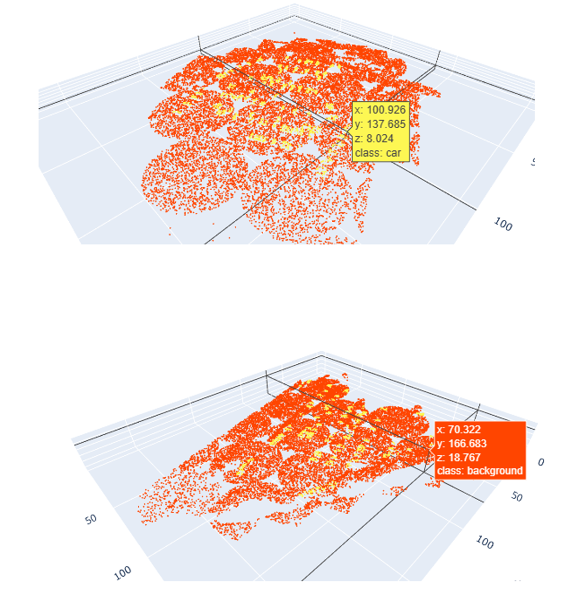

In [12]:
# Visualize a batch of training samples
# Shows point-cloud tiles with class colors applied
# ------------------------------------------------------------
data.show_batch(rows = 2)

Below is an animated demonstration of how these point-cloud tiles can be explored interactively:

<p align="center"><img src="../../static/img/pointcnn_sample2_show_b.gif" /></p>

<center>Figure 3. Visualization of batch.</center>

## <a id='toc1_7_'></a>[Training the model](#toc0_)

After verifying that the dataset has been loaded correctly, we can initialize the deep learning model. In this workflow, we use `RandLANet`.

**RandLANet** is a neural network architecture optimized for **semantic segmentation (or classification) of large point clouds**. It was originally proposed in the paper *RandLA-Net: Efficient Semantic Segmentation of Large-Scale Point Clouds* by Hu et al., and uses **random sampling** and a **local-feature aggregation module** to remain both memory- and compute-efficient while preserving fine geometric detail.

In ArcGIS, the `arcgis.learn` module provides a native implementation of RandLANet, which is ideal for classifying or segmenting LAS/LASD point-cloud data. It handles per-point features and is built to scale to very large point sets. For full reference and advanced options, see the ArcGIS API for Python documentation: [RandLANet (arcgis.learn) — API Reference](https://developers.arcgis.com/python/latest/api-reference/arcgis.learn.toc.html#randlanet)

In [13]:
# Create a model object using the prepared data
# ------------------------------------------------------------

model_r = RandLANet(                         # Create a RandLANet model object
                    data,                   # The DataBunch object returned from prepare_data()
                    pretrained_path=None,   # Optional: path to a pre-trained model. If you have a saved RandLANet model, you can pass its path here to fine-tune or resume training.
                    focal_loss=False        # Optional: whether to use focal loss (helpful for class imbalance)
                   )

# Confirms that the model was successfully created
print("RandLANet model object initialized...")

RandLANet model object initialized...


Before training RandLANet, it is good practice to determine an **optimal learning rate (LR)** — the parameter that controls how quickly the model updates its weights during training by newly acquired information throughout the training process.  

ArcGIS's implementation provides the method **`lr_find()`**, which performs a learning-rate range test and identifies a value where the loss begins to decrease steadily without becoming unstable.

If you do **not** specify a learning rate manually during training, the value from the learning curve by `lr_find()` will be extracted and used automatically.

In [14]:
# 📈 Run Learning Rate Finder
# ------------------------------------------------------------
# Find an optimal learning rate for training RandLANet
# This runs a learning-rate range test and identifies
# the LR that leads to stable, smooth reduction in loss.
# ------------------------------------------------------------

optimal_lr = model_r.lr_find()

# Display the suggested learning rate
optimal_lr

0.0015848931924611132

This value can now be passed directly into `model_r.fit(...)` for effective and stable training.

Once the data has been prepared and visually verified, the next major step is **training the RandLANet point-cloud segmentation model**. Training is performed using the `fit()` method, which controls how the model learns from the input point-cloud blocks. The `fit()` method trains the model for a specified number of epochs using a selected learning rate and various training options. Here are the key concepts involved:

#### <a id='toc1_7_1_1_'></a>[**🔹 Learning Rate (`optimal_lr`)**](#toc0_)
The learning rate controls **how quickly the model updates its parameters**. You can either:
- Use LR found via lr_find() → `model_r.fit(epochs, lr=optimal_lr)`
- Use a custom LR → `model_r.fit(epochs, lr=0.0001)`
- Let the model choose automatically → `model_r.fit(epochs)`

A good LR leads to stable learning, while a poor LR causes divergence or very slow progress.

#### <a id='toc1_7_1_2_'></a>[**🔹 Early Stopping**](#toc0_)
If `early_stopping=True`, training will automatically stop when the monitored metric stagnates or worsens, regardless of the `epochs` parameter value specified. This prevents unnecessary training and avoids overfitting. The best model is selected based on the metric selected in the `monitor` parameter. 

#### <a id='toc1_7_1_3_'></a>[**🔹 Choosing a Metric to Monitor**](#toc0_)
The model uses the metric provided in `monitor` to decide when improvements occur.  
You can list all available metrics using:
```python
        model_r.available_metrics
```
Most segmentation tasks benefit from monitoring the **F1 score**, as it balances precision and recall.

#### <a id='toc1_7_1_4_'></a>[**🔹 Epochs**](#toc0_)

An epoch means the entire training dataset has been passed once through the network.
If `Iters_per_epoch` is set, only a subset is used per epoch.

#### <a id='toc1_7_1_5_'></a>[**🔹 TensorBoard Logging**](#toc0_)

Setting `tensorboard=True` enables logging of metrics, losses, gradients, and learning rate curves.
You can view training progress live using:
```python
        tensorboard --host=<machine-name> --logdir="<path-to-training-log>"
```

In [15]:
# List all possible metrics
# ------------------------------------------------------------

model_r.available_metrics

['valid_loss', 'accuracy', 'precision', 'recall', 'f1']

In [16]:
# Train the RandLANet model.
# ------------------------------------------------------------

# Key Parameters:
# - epochs: number of full passes over the data
# - lr: learning rate (use lr_find() output or custom value)
# - monitor: metric used to track improvement (e.g., 'f1')
# - early_stopping: stops training if no improvement is seen
# - tensorboard: log training data for real-time monitoring
# ------------------------------------------------------------

model_r.fit(
    epochs=10,            # Train for 10 epochs (adjust as needed)
    lr=optimal_lr,        # Learning rate (derived from lr_find or custom)
    monitor='f1',         # Use F1-score to track improvements
    tensorboard=True,     # Enable TensorBoard logging
    early_stopping=True   # Stop early if performance plateaus
)

Monitor training on Tensorboard using the following command: 'tensorboard --host=DELDEVD020 --logdir="C:\Users\Neh13173\AppData\Local\Temp\Classification_of_sfm_derived_point_clouds_using_deep_learning\project\exported_data.pctd\training_log"'


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.011713,0.159786,0.965640,0.775429,0.579709,0.597182,31:45
1,0.004081,0.267743,0.970054,0.861797,0.680228,0.704978,31:35
2,0.003258,0.185177,0.971201,0.926257,0.710056,0.740527,31:40
3,0.003113,0.135830,0.974185,0.946175,0.743688,0.786724,31:45
4,0.002662,0.124728,0.970974,0.934491,0.708597,0.742624,31:36
5,0.002697,0.273754,0.962748,0.802649,0.654360,0.646643,31:44
6,0.002660,0.203751,0.966357,0.907717,0.674932,0.692295,31:36
7,0.002512,0.125969,0.969871,0.918401,0.707353,0.735543,31:26
8,0.002514,0.057360,0.984439,0.902549,0.811355,0.840801,31:37
9,0.004375,0.087371,0.979238,0.889398,0.761532,0.795978,31:36


When training the **RandLANet** model, each epoch logs several metrics that describe how well the model is learning. Below is a general explanation of what each metric means and how to interpret the pattern of convergence over multiple epochs.

🔵 **1. Train Loss**
It reflects how well the model is fitting the training blocks. In the early epochs, it should steadily decrease. Once it begins to flatten, the model has learned most of the patterns available in the training set. A smooth downward trend also indicates that the learning rate is stable.

🟣 **2. Validation Loss**
It shows performance on unseen data. Ideally, it should follow the trend of training loss. Minor fluctuations are normal; large upward spikes could suggest overfitting. In this case, validation loss stays fairly stable, indicating good generalization.

🟢 **3. Accuracy**
Accuracy usually appears high in point-cloud segmentation because the background class dominates. Small improvements across epochs show that the model is learning to classify minority classes (e.g., cars) more effectively.

🟠 **4. Precision**
Precision measures how many predicted positive points are **actually correct**.
- Increasing precision means the model is producing **fewer false positives**.
- If precision stays stable across epochs, the model is making consistent and reliable predictions.
In the observed training, precision steadily improves early on and then stabilizes, a sign of solid convergence.

🟡 **5. Recall**
Recall measures how many actual positive points the model **successfully detected**.
- Increasing recall means fewer **missed detections**.
- A balanced recall curve shows the model is capturing more object points across epochs.
Recall shows a strengthening trend early in training and stabilizes later, which is expected as the model converges.

🟤 **6. F1-Score**
F1 is the harmonic mean of precision and recall—a key metric for **imbalanced segmentation** tasks. The F1-score, which balances precision and recall, typically increases for the first few epochs and then levels off. A stable F1 curve is one of the best indicators that the model has reached a reliable state.

📈 **Overall Convergence Pattern**

Across epochs, the model shows a **healthy convergence pattern**. The model has reached a **stable and generalizable state**.
- Both **train_loss** and **valid_loss** remain low and stable.
- The learning rate is appropriate.
- **F1-score**, **precision**, and **recall** improve initially and then plateau  
- No signs of divergence or strong overfitting  
- Minor oscillations in metrics are normal due to:
  - Variation between point-cloud blocks
  - Random sampling layers in RandLANet
  - Data complexity and class imbalance
- Additional epochs may produce **small gains**, but major changes are unlikely.
- The model is now ready for **validation, results visualization, and inference**.

## <a id='toc1_8_'></a>[Visualization of results in notebook](#toc0_)

After training the RandLANet segmentation model, it is useful to **visually compare** the predicted classes with the ground-truth labels to verify classes, the model's performance on unseen data, classification quality, etc.  The `show_results()` method displays point-cloud tiles side-by-side:
- **Left:** Ground-truth labels  
- **Right:** Model predictions  
- **Colors:** Defined from the earlier `color_mapping`  
- **Navigation:** Zoom, rotate, and pan within the 3D plot  

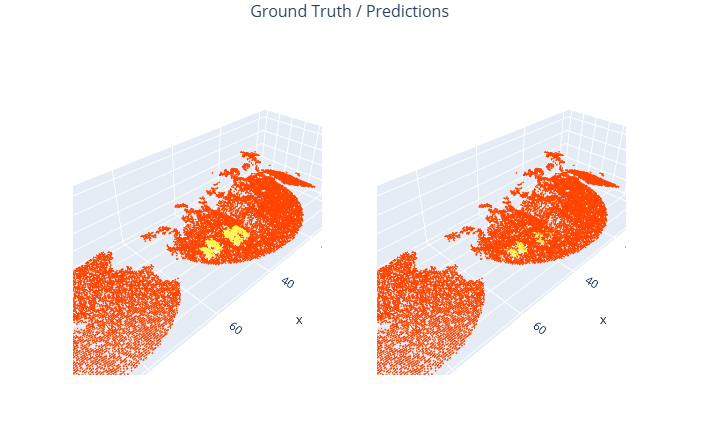

In [17]:
# Visualize prediction vs ground truth for a sample block
# - rows: number of samples to display
# ------------------------------------------------------------

model_r.show_results(rows=1)

Below is an animated demonstration of how these classified point-cloud tiles can be explored interactively -

<p align="center"><img src="../../static/img/pointcnn_sample2_show_r.gif" /></p>

<center>Figure 4. Visualization of results.</center>

The `compute_precision_recall()` method can be used to compute per-class performance metrics. For a deeper evaluation, it calculates:
- **Precision per class**
- **Recall per class**
- **F1-score per class**
  
These metrics are evaluated using the **validation dataset**, not the training data, making them useful indicators of true model performance.

In [18]:
# Compute per-class precision, recall, and F1-score
# Results are printed in a class-wise summary table
# ------------------------------------------------------------

model_r.compute_precision_recall()

,background,car
precision,0.986170,0.917072
recall,0.997749,0.640166
f1_score,0.991926,0.754000


## <a id='toc1_9_'></a>[Saving the trained model](#toc0_)

After confirming that the model is learning effectively and achieving good validation metrics, the final step is to **save the trained RandLANet model**. ArcGIS automatically packages several important components when using the `save()` method.

#### <a id='toc1_9_1_1_'></a>[🎯 What Gets Saved?](#toc0_)

When you call `save()`, the following items are generated:

- **Model Metrics**—model name, backbone, learning rate, etc
- **Esri Model Definition (EMD)**—describes model architecture, classes, data attributes, etc. Required when reloading the model using `from_model()`. 
- **Deep Learning Package (DLPK)**—deployable asset for **ArcGIS Pro** & **ArcGIS Image Server**  
- **PyTorch Weights (.pth)**—raw model weights for further fine-tuning  
- **ModelCharacteristics folder**—includes visualizations such as prediction vs. ground truth  

These files are essential for: 
- ✔️ Running inference inside **ArcGIS Pro**  
- ✔️ Deploying to **ArcGIS Image Server**  
- ✔️ Sharing the model with others  
- ✔️ Reloading and retraining later  

In [19]:
# Save the trained RandLANet model
# ------------------------------------------------------------

# - Saves model weights, EMD file, metrics, visuals, etc.
# - Creates a complete deep learning package
# - `publish=True` automatically publishes the DLPK to ArcGIS Online/Enterprise (if GIS session is active)
# - Timestamp ensures unique versioning

# Generate a unique timestamp (e.g., 20250210_143522)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Create model name using timestamp
model_name = f"cars_and_background_{timestamp}"

print(f"Saving model as: {model_name}")

# Save the model (creates model folder + EMD + DLPK)
model_r.save(model_name, publish = True)

Saving model as: cars_and_background_20251127_041858
Computing model metrics...
Published DLPK Item Id: 468f7f76c76544f6ad83af4853de352d


WindowsPath('C:/Users/Neh13173/AppData/Local/Temp/Classification_of_sfm_derived_point_clouds_using_deep_learning/project/exported_data.pctd/models/cars_and_background_20251127_041858')

### <a id='toc1_9_2_'></a>[📦 Saved model folder structure](#toc0_)

After training completes, the model is saved with a timestamped name to ensure versioning and reproducibility.  
The saved directory contains all files required for **inference, deployment, documentation, or future fine-tuning**.

#### <a id='toc1_9_2_1_'></a>[📁 Example Folder Structure](#toc0_)
```Python
            ─cars_and_background_20251126_023235
                │   cars_and_background_20251126_023235.dlpk
                │   cars_and_background_20251126_023235.emd
                │   cars_and_background_20251126_023235.pth
                │   model_metrics.html
                │
                └───ModelCharacteristics
                        show_results.html
```

### Fetch published model

Once the model is saved with `publish=True`, ArcGIS automatically publishes the Deep Learning Package (DLPK) to your **ArcGIS Online/Enterprise** account.  
This enables you to:

- Use the model for inferencing directly inside the notebook, even if the notebook restarts after model training and saving.  
- Run classification using ArcGIS Pro tools or arcpy script. 
- Share the model across your organization or publicly.

Below, we retrieve the published model by using its **item ID**, which was displayed in the previous cell during the save process.

In [20]:
# Fetch the published Deep Learning Package (DLPK) from ArcGIS Online
# -------------------------------------------------------------------

published_model = gis.content.get('468f7f76c76544f6ad83af4853de352d')  # DLPK Item ID of your saved model from previous cell
published_model

<Item title:"cars_and_background_20251127_041858" type:Deep Learning Package owner:arcgis_python>

## <a id='toc1_10_'></a>[Classification using the trained model (Inferencing)](#toc0_)

Once the RandLANet model has been trained and saved, it can be used to **classify new point cloud data (test data)** in TWO ways:
1. Using ArcGIS Pro GUI tool — Classify Point Cloud Using Trained Model
2. Using ArcPy (as shown below) directly inside this notebook.

### <a id='toc1_10_1_'></a>[Classify Point Cloud Using Trained Model (available from ArcGIS Pro 2.8+)](#toc0_)

Using the **<a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst Extension</a>** extension, the *Classify Point Cloud Using Trained Model* tool allows you to run inferencing on LAS/LAZ point clouds directly inside **ArcGIS Pro**.
- Open the tool: **Classify Point Cloud Using Trained Model**
- Select LAS dataset and trained model
- Run directly inside Pro

This tool supports several useful options:

- **Target Classification**—Allows you to assign specific output class codes for detected features  
- **Preserve Existing Classes**—Keeps untouched any point classes you do not want the model to overwrite  
- **GPU Acceleration**—Uses available GPU for fast inferencing (if supported)

<center>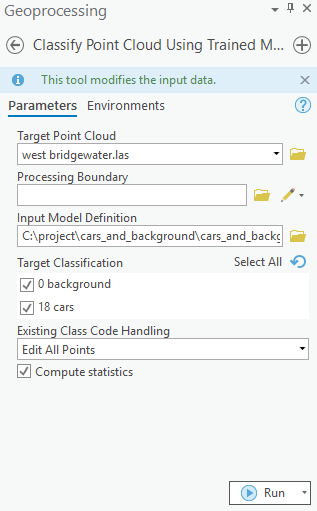</center>

<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool.</center>


### <a id='toc1_10_2_'></a>[Using ArcPy](#toc1_)

In [21]:
# Fetch the model and test data local paths
# ------------------------------------------------------------

saved_model_local_path = os.path.join(exported_data_path, "models", model_name)             # Build the full local path to the trained model
test_point_cloud_path = os.path.join(output_path, "test data", "west bridgewater.las")      # Build full path for the test point cloud LAS file

In [22]:
# Perform inferencing using the ArcPy
# --------------------------------------------------------------
# This script applies the trained deep learning model to classify LAS points. This tool modifies the input test data.

arcpy.ddd.ClassifyPointCloudUsingTrainedModel(
    in_point_cloud = test_point_cloud_path,   # LAS file to classify
    in_trained_model = saved_model_local_path, # Folder containing the trained model
    output_classes = "0;18",                   # Class code: 18 = Cars, 0 = Background
    in_class_mode = "EDIT_ALL",                # Edit all existing class codes
    target_classes = [],                       # No specific target classes
    compute_stats = "COMPUTE_STATS",           # Recompute LAS statistics after classification
    boundary = None,                           # No classification boundary mask
    update_pyramid = "UPDATE_PYRAMID",         # Update LAS pyramid for quick display
    reference_height = None,
    excluded_class_codes = [],
    batch_size = None,                         # Let the tool auto-detect optimal batch size
)

<Result ''>

After inference completes:

- Points classified as **cars** will receive **class code `18`.**  
- All other points will receive **class code `0`** (Background)

These class codes can be customized in the tool settings if needed.

To visualize the output clearly:

1. Select the LAS dataset in the **Contents Pane.**  
2. Go to the **Appearance** tab.  
3. Set **Symbology → Color By → Class**  

This will color-code your LAS points based on the classification results, making the extracted cars easy to inspect.

## <a id='toc1_11_'></a>[Visualization of results in ArcGIS Pro](#toc0_)

<center>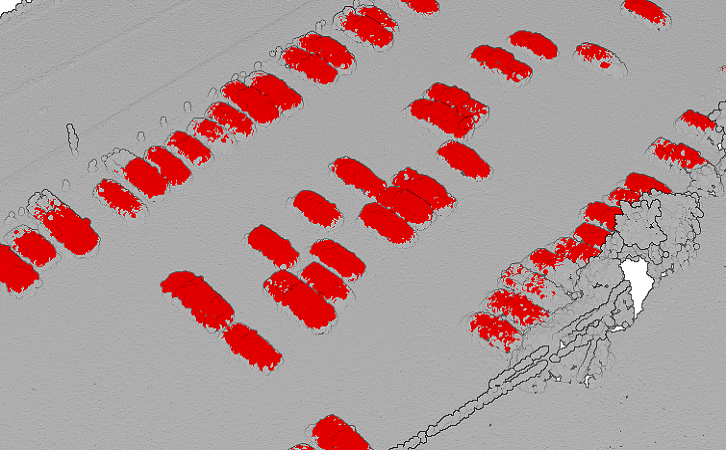</center>

<center>Figure 7. Visualization of results in ArcGIS Pro.</center>

## <a id='toc1_12_'></a>[Visualization of Results in a Web Scene (ArcGIS Notebooks)](#toc0_)

The processed result related to the illustrated test data in this notebook is already stored as an item on **ArcGIS Online**. You can load and visualize it using a **web scene** as shown below.

<Item title:"Classification of SfM-derived point clouds using deep learning" type:Web Scene owner:api_data_owner>
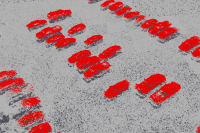

In [23]:
# Retrieve the web scene using its itemId
# ------------------------------------------------------------
# The following code loads the processed 3D Web Scene (containing the classified point cloud) from your GIS.  
# The itemId uniquely identifies content stored in ArcGIS Online or ArcGIS Enterprise.
# Here, we use the GIS connection (gis) to fetch the web scene item.
# This item contains the classified point cloud visualization.

results = gis.content.get('6a50627e143c47fe9f040a4b5eb5a86e')

# Display the metadata of the retrieved item.
results

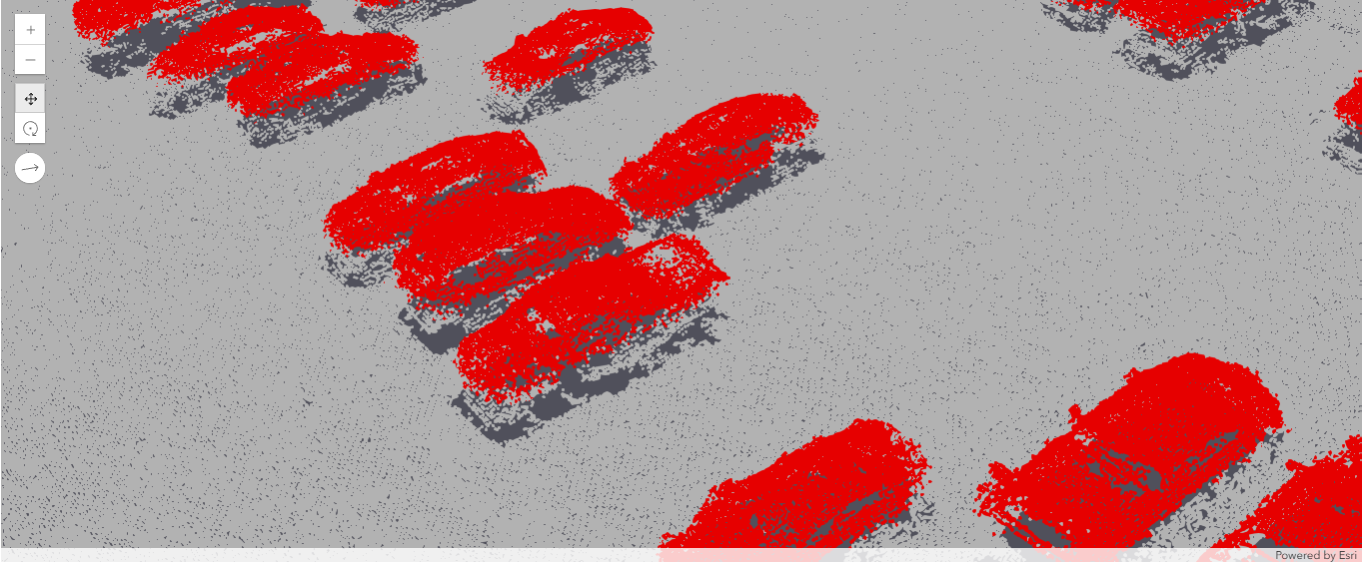

In [24]:
# Display the 3D Web Scene inside the notebook
# ------------------------------------------------------------

scene1 = Scene(item = results)
scene1

## <a id='toc1_13_'></a>[Conclusion](#toc0_)

This workflow demonstrates the complete process of classifying SfM-derived point clouds using deep learning with ArcGIS and RandLANet. Key steps include:

- **Data Preparation** – Exporting point-cloud tiles in the **PCTD format**, adding extra features such as RGB, and filtering to retain informative blocks.
- **Model Training** – Using **RandLANet** with optimized hyperparameters, including batch size, learning rate, and early stopping, to achieve stable convergence.
- **Validation and Metrics Monitoring** – Evaluating model performance with metrics like F1-score, precision, recall, and loss, ensuring generalization to unseen data.
- **Model Saving and Deployment** – Packaging the trained model into **DLPK** for **ArcGIS Pro**, **ArcGIS Online**, or future retraining.
- **Inference and Visualization** – Classifying points in LAS datasets, visualizing results in **ArcGIS Pro** **3D Web Scenes** for interactive inspection.

This workflow illustrates how deep learning can effectively segment objects of interest, such as cars, in large-scale point-cloud datasets. The approach is scalable, reproducible, and adaptable to other classes like trees, buildings, or terrain, providing a robust framework for point-cloud analysis and GIS applications.

## <a id='toc1_14_'></a>[References](#toc0_)

- Dharmapuri, S., & Tully, M. (2018). Evolution of Point Cloud. LIDAR Magazine. https://lidarmag.com/2018/07/16/evolution-of-point-cloud/





<center><i>****End of notebook****</i></center>